In [2]:
from os import path, listdir, mkdir
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(rc={'grid.linewidth' : 1, 'figure.facecolor':'white'})
sns.set(style = 'whitegrid')
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

Data processing pipeline:
1. Download raw files from datasets PXD022836, PXD022868, PXD006442 (MS2) and PXD035055 (MS1)
2. Convert raw files to mzML with $ \textit{msConvert}$
        input: raw files (step 1)
        output: mzML files
3. Perform peptide spectrum matching of LC-MS/MS data with search engines $ \textit{IdentiPy}$, $\textit{MSFragger}$, or $\textit{X!Tandem}$. For LC-MS1 data $\textit{ms1searchpy}$ can be used
        input: mzML file (step 2)
        output: pepxml file
4. Perform search post-processing and calculation of NSAF values with $ \textit{Scavager}$
        input: pepxml file (step 3)
        output: PSMs, peptides, proteins and protein_groups files
5. Perform quantitative analysis with $\textit{Diffacto}$ or with stat_test.ipynb from https://github.com/kazakova/Metrics
        input: Scavager output files for Diffacto or protein_groups file for stat_test (step 4)
        ouput: tab-separated file with quantitative analysis results (for diffacto fold_change and fdr_BH should
        be calculated manually):
            NSAF_t-test_*.tsv
6. Calculate metrics with metrics.ipynb from https://github.com/kazakova/Metrics
        input: tab-separated file(-s) with quantitative analysis results (step 5)
        output: tab-separated file and scatterplots with calculated metrics for all the files provided:
            metrics_*.tsv
7. Select DE expressed proteins (de_gene_list from https://github.com/kazakova/Metrics/blob/main/GO_terms_analysis.ipynb)
        input: tab-separated file with quantitative analysis results (step 5)
        output: 3 comma-separated files with positively and negatively regulated DE proteins and their aggregate (UP, DOWN,
        DE):
            genes_*_UP.csv, genes_*_DOWN.csv, genes_*_DE.csv
8. Perform GO terms enrichment analysis (show_string_picture and load_go_enrichment from
    https://github.com/kazakova/Metrics/blob/main/GO_terms_analysis.ipynb)
        input: comma-separated file with DE proteins (step 7)
        output: tab-separated file with identified GO terms and protein network plot
9. Select processes from GO analysis results and calculate Enrichment and GO score (formulas can be found below;
    enrichment_calculation from https://github.com/kazakova/Metrics/blob/main/GO_terms_analysis.ipynb)
        input: tap-separated file with identified GO terms (step 8)
        output: tab-separated file with identified processes, their enrichments and GO scores (sorted by GO score):
            *.string.enrichment_processes.tsv
10. Сombine topN processes for different data in one dataframe (top_processes from
    https://github.com/kazakova/Metrics/blob/main/GO_terms_analysis.ipynb)
        input: tab-separated files with identified processes, their enrichments and GO scores (sorted by GO score) (step 9)
        ouput: tab-separated file with processes and their GO scores calculated on different data:
            topN_processes_*.tsv

$$ Enrichment = log_{10}(\frac{proteome \ size}{number \ of \ DE \ genes} \cdot \frac{number \ of \ DE \ genes \ contributing \ to \ process}{number \ of \ genes \ in \ background}) $$

$$ GO \ score = Enrichment \cdot |log_{10} (fdr)| $$

# Fig 1

Input files contain GO terms enrichment analysis results (step 8 from the pipeline)

In [2]:
path_to_data = {'DBTRG&HOS IFNa' : '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/a172_dbtrg',
                    'GBM2017 IFNa' : '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/glioblastoma_2017_infa',
                    'GBM2017 IFNb' : '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/glioblastoma_2017_infb',
                    'GBM2019 IFNa' : '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/glioblastoma_2019',
                    'MRC5 IFNa': '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/time_infa',
                    'MRC5 IFNg' : '/home/kae-13-1/Metrics/Jan2022/18_01/MinDet/time_infg'}

dataname_to_plot = {'a172_dbtrg_DBTRG' :  'DBTRG IFNa-2b 1000 24h',
                    'a172_dbtrg_A172' : 'HOS IFNa-2b 1000 24h',
                    'glioblastoma_2019_AN' : 'AN IFNa-2b 100 24h',
                    'glioblastoma_2019_6067' : 'GBM6067 IFNa-2b 100 24h',
                    'glioblastoma_2019_3821' : 'GBM3821 IFNa-2b 100 24h',
                    'glioblastoma_2019_5522' : 'GBM5522 IFNa-2b 100 24h',
                    'glioblastoma_2019_4114' : 'GBM4114 IFNa-2b 100 24h',
                    'glioblastoma_2017_infa_i' : 'GBM2017i IFNa-2b 100 24h',
                    'glioblastoma_2017_infa_b' : 'GBM2017b IFNa-2b 100 24h',
                    'glioblastoma_2017_infb_i' : 'GBM2017i IFNb-2b 1000 24h',
                    'glioblastoma_2017_infb_b' : 'GBM2017b IFNb-2b 1000 24h',
                    'time_infa_48' : 'MRC5 IFNa-2b 500 48h',
                    'time_infa_24' : 'MRC5 IFNa-2b 500 24h',
                    'time_infa_4' : 'MRC5 IFNa-2b 500 4h',
                    'time_infg_48':'MRC5 IFNg 500 48h',
                    'time_infg_24' : 'MRC5 IFNg 500 24h',
                    'time_infg_4' : 'MRC5 IFNg 500 4h'}

reg_type = '_GO'

n_genes = pd.DataFrame()
processes_set = set()

ffolders = list(path_to_data.values())
dirs = [f + '/GO' for f in ffolders]

In [3]:
for ffolder in ffolders:
    for file in listdir(ffolder):
        if (file.endswith(reg_type + '.csv')) and ('stat' in file):
            df = pd.read_csv(path.join(ffolder, file))
            dataname=  file.split(reg_type)[0] 
            n_genes.loc[dataname, 'n'] = df.shape[0]
###################            
for ffolder in dirs:
    for file in listdir(ffolder):
        if (file.endswith(reg_type + '.string.enrichment.tsv')) and ('stat' in file):
            d = pd.read_csv(path.join(ffolder, file), sep = '\t')
            d = d[d['category'] == 'Process']
            d['-log10(fdr)'] = d['fdr'].apply(lambda x: -np.log10(x))
            
            n_g = n_genes.loc[file.split(reg_type)[0], 'n']
            
            d['enrichment'] = d['number_of_genes'] * 20000/d['number_of_genes_in_background']/n_g
            d['enrichment'] = d['enrichment'].apply(lambda x: np.log10(x))
            
            d['metric'] = d['-log10(fdr)'] * d['enrichment']
            
            d = d.sort_values(by = 'metric', ascending = False)
            df = d.head(10)
            tmp = list(df['description'].values)
        
            processes_set.update(tmp)
##################
processes_stat = pd.DataFrame(list(processes_set), columns = ['description'])
for ffolder in dirs:
    for file in listdir(ffolder):
        if (file.endswith(reg_type + '.string.enrichment.tsv')) and ('stat' in file): 
            dataname = file.split('_stat')[0] + file.split('_stat')[1].split(reg_type)[0]   
            d = pd.read_csv(path.join(ffolder, file), sep = '\t')
            d = d[d['category'] == 'Process']
            d['-log10(fdr)'] = d['fdr'].apply(lambda x: -np.log10(x))
            
            n_g = n_genes.loc[file.split(reg_type)[0], 'n']
                
            d['enrichment'] = d['number_of_genes'] * 20000/d['number_of_genes_in_background']/n_g
            d['enrichment'] = d['enrichment'].apply(lambda x: np.log10(x))
            
            d['metric'] = d['-log10(fdr)'] * d['enrichment']
            
            processes_stat = processes_stat.merge(right = d[['description','metric']], how = 'left',
                                                               on = 'description')
            processes_stat = processes_stat.rename(columns = {'metric' : dataname_to_plot[dataname]})

In [4]:
colors = sns.color_palette('Set2', 6)
legend_elements = [
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[0], marker = 's', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'HOS IFNa 1000'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[2], marker = 's', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM2017b IFNa 100'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[4], marker = 's', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'MRC5 IFNa 500'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[5], marker = 's', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'MRC5 IFNg 500'),
                   Line2D ([0], [0], color = 'w', label = 'Positive controls'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[0], marker = 'o', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'DBTRG IFNa 1000'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[1], marker = 'o', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM2019 IFNa 100'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[2], marker = 'o', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM2017i IFNa 100'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[3], marker = 'o', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM2017i IFNb 1000'),
                   Line2D ([0], [0], color = 'w', label = 'Negative controls'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[1], marker = 'X', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM4114 IFNa 100'),
                   Line2D([0], [0], color = 'w', markerfacecolor = colors[3], marker = 'X', markersize = 10,
                          markeredgecolor = 'k',  markeredgewidth = .1, label = 'GBM2017b IFNb 1000'),
                 ]
hue_order = ['DBTRG&HOS IFNa', 'GBM2019 IFNa', 'GBM2017 IFNa', 'GBM2017 IFNb', 'MRC5 IFNa', 'MRC5 IFNg']

pos = ['GBM6067 IFNa-2b 100 24h', 'AN IFNa-2b 100 24h', 'GBM2017i IFNb-2b 1000 24h',
      'GBM2017i IFNa-2b 100 24h', 'GBM5522 IFNa-2b 100 24h', 'GBM3821 IFNa-2b 100 24h',
      'DBTRG IFNa-2b 1000 24h']

neg = ['GBM2017b IFNb-2b 1000 24h', 'GBM4114 IFNa-2b 100 24h']

markers = {"pos": "o", 
           "neg": "X",
            'notcontrol' : 's'}

data_to_dataset = {'GBM6067 IFNa-2b 100 24h': 'GBM2019 IFNa',
                     'AN IFNa-2b 100 24h': 'GBM2019 IFNa',
                     'GBM2017i IFNb-2b 1000 24h': 'GBM2017 IFNb',
                     'GBM2017i IFNa-2b 100 24h': 'GBM2017 IFNa',
                     'MRC5 IFNa-2b 500 48h': 'MRC5 IFNa',
                     'HOS IFNa-2b 1000 24h': 'DBTRG&HOS IFNa',
                     'GBM5522 IFNa-2b 100 24h': 'GBM2019 IFNa',
                     'GBM3821 IFNa-2b 100 24h': 'GBM2019 IFNa',
                     'DBTRG IFNa-2b 1000 24h': 'DBTRG&HOS IFNa',
                     'GBM4114 IFNa-2b 100 24h': 'GBM2019 IFNa',
                     'MRC5 IFNa-2b 500 24h': 'MRC5 IFNa',
                     'MRC5 IFNg 500 48h': 'MRC5 IFNg',
                     'MRC5 IFNa-2b 500 4h': 'MRC5 IFNa',
                     'GBM2017b IFNa-2b 100 24h': 'GBM2017 IFNa',
                     'MRC5 IFNg 500 24h': 'MRC5 IFNg',
                     'MRC5 IFNg 500 4h': 'MRC5 IFNg',
                     'GBM2017b IFNb-2b 1000 24h': 'GBM2017 IFNb'}

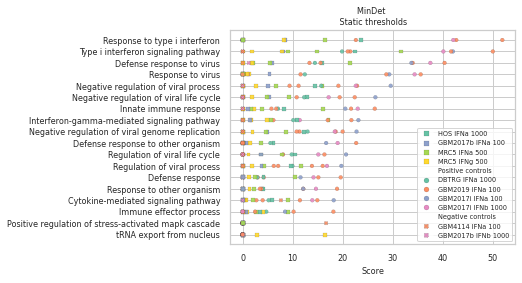

In [6]:
#### Fig 1a
sns.set_palette('Set2', 6)
cm = 1/2.54
processes = [processes_stat]

names = ['MinDet \n Static thresholds']

plt_dir = '/home/kae-13-1/Metrics'

for dataset, name in list(zip(processes, names)):
    
    tmp_df = pd.DataFrame(columns = ['description', 'value', 'data'])
    dataset = dataset.set_index('description')
    dataset = dataset.fillna(value = 0)
    cols = dataset.columns
    
    dataset['maxscore'] = dataset.max(axis = 1)
    dataset = dataset[dataset['maxscore'] >= 15]
    dataset = dataset.drop(axis = 1, labels = ['maxscore'])
    
    for col in cols:
        for i in dataset.index:
            tmp = pd.DataFrame([[col, i, dataset.loc[i, col]]], columns = ['data', 'description', 'value'])
            tmp_df = pd.concat([tmp_df, tmp], ignore_index = True)
    tmp_df['description'] = tmp_df['description'].apply(lambda x: x.replace('Antigen processing and presentation', 'APP'))
    
    tmp_df = tmp_df.sort_values(by = 'value', ascending = False)
    tmp_df['dataset'] = tmp_df.data.apply(lambda x: data_to_dataset[x])
    tmp_df['controls'] = None
    
    for p in tmp_df.index:
        if tmp_df.loc[p, 'data'] in pos:
            tmp_df.loc[p, 'controls'] = 'pos'
        elif tmp_df.loc[p, 'data'] in neg:
            tmp_df.loc[p, 'controls'] = 'neg'
        else:
            tmp_df.loc[p, 'controls'] = 'notcontrol'
    
    y_len = len(tmp_df['description'].unique())
    f, ax = plt.subplots(figsize = (13*cm, 10*cm))
    sp = sns.scatterplot(x = 'value', y = 'description', hue = 'dataset',  hue_order = hue_order,
                         edgecolor = 'black', linewidth = .1, style = 'controls', markers = markers,
                         data = tmp_df, ax = ax, s = 15, alpha = 0.9)
    ax.tick_params(axis = 'both', labelsize = 8)
    ax.set_xlabel('Score', fontsize = 8)
    ax.set_ylabel(None)
    ax.set_title(name, fontsize = 8)
    plt.legend(handles = legend_elements, fontsize = 6.5, markerscale = .5)
#     f.savefig(path.join(plt_dir, 'Fig1a.png'), dpi = 600, bbox_inches = 'tight')
#     f.savefig(path.join(plt_dir, 'Fig1a.svg'), dpi = 600, bbox_inches = 'tight')
    plt.show()

In [16]:
#### Fig 1b
sns.set_palette('Set2', 6)
cols = [i for i in processes_stat.columns if 'MRC5' in i] + ['description']
cm = 1/2.54

processes = [processes_stat]
names = ['MinDet \n Static thresholds']
plt_dir = '/home/kae-13-1/Metrics'
hue_order = ['MRC5 IFNa-2b 500 48h',
            'MRC5 IFNa-2b 500 24h',
            'MRC5 IFNa-2b 500 4h',
            'MRC5 IFNg 500 48h',
            'MRC5 IFNg 500 24h',
            'MRC5 IFNg 500 4h']

for dataset, name in list(zip(processes, names)):
    dataset = dataset[cols]
    tmp_df = pd.DataFrame(columns = ['description', 'value', 'data'])
    
    dataset = dataset.set_index('description')
    dataset = dataset.fillna(value = 0)
    cols = dataset.columns
    
    dataset['maxscore'] = dataset.max(axis = 1)
    dataset = dataset[dataset['maxscore'] >= 15] 
    dataset = dataset.drop(axis = 1, labels = ['maxscore']) 
    
    for col in cols:
        for i in dataset.index:
            tmp = pd.DataFrame([[col, i, dataset.loc[i, col]]], columns = ['data', 'description', 'value'])
            tmp_df = pd.concat([tmp_df, tmp], ignore_index = True)
    tmp_df['description'] = tmp_df['description'].apply(lambda x: x.replace('Antigen processing and presentation', 'APP'))
    
    tmp_df = tmp_df.sort_values(by = 'value', ascending = False)
    
    y_len = len(tmp_df['description'].unique())
    f, ax = plt.subplots(figsize = (13*cm, 4*cm))
    sp = sns.scatterplot(x = 'value', y = 'description', hue = 'data', hue_order = hue_order,
                         edgecolor = 'black', linewidth = .1, 
                         data = tmp_df, ax = ax, s = 15)
    ax.tick_params(axis = 'both', labelsize = 8)

    ax.set_xlabel('Score', fontsize = 8)
    ax.set_ylabel(None)
    ax.set_title(name, fontsize = 8)
    plt.legend(fontsize = 6.5, markerscale = .5)
    f.savefig(path.join(plt_dir, 'Fig1b.png'), dpi = 600, bbox_inches = 'tight')
    f.savefig(path.join(plt_dir, 'Fig1b.svg'), dpi = 600, bbox_inches = 'tight')
    plt.close()

# Fig S1

Input files contain calculated metrics (step 6 from the pipeline)

In [10]:
sns.color_palette('RdYlGn', 6)

[(0.8899653979238754, 0.2867358708189158, 0.19815455594002307),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.8918877354863515, 0.954479046520569, 0.6010765090349867),
 (0.6165321030372937, 0.8359092656670513, 0.41191849288735105),
 (0.22468281430219145, 0.6558246828143022, 0.3444059976931949)]

In [11]:
colors  = sns.color_palette('rainbow', 6)
markers = {"UP": "o", "DOWN": "X"}
hue_order = ['DBTRG&HOS IFNa',
             'GBM2017 IFNa',
             'GBM2017 IFNb',
             'GBM2019 IFNa',
             'MRC5 IFNa',
             'MRC5 IFNg']

metrics_data_dir = '/home/kae-13-1/Metrics/Mar2022/16_03'
metrics_kNN_dyn = pd.DataFrame()
metrics_kNN_semi_dyn = pd.DataFrame()
metrics_kNN_stat = pd.DataFrame()
metrics_MinDet_dyn = pd.DataFrame()
metrics_MinDet_semi_dyn = pd.DataFrame()
metrics_MinDet_stat = pd.DataFrame()

for file in listdir(metrics_data_dir):
    if file.startswith('metrics'):
        d = pd.read_csv(path.join(metrics_data_dir, file), delimiter = '\t', index_col = 0)
        if 'knn' in file:
            if '_dyn' in file:
                metrics_kNN_dyn = pd.concat([metrics_kNN_dyn, d], axis = 1)
            elif '_semi' in file:
                metrics_kNN_semi_dyn = pd.concat([metrics_kNN_semi_dyn, d], axis = 1)
            if '_stat' in file:
                metrics_kNN_stat = pd.concat([metrics_kNN_stat, d], axis = 1)
        elif 'mindet' in file:
            if '_dyn' in file:
                metrics_MinDet_dyn = pd.concat([metrics_MinDet_dyn, d], axis = 1)
            elif '_semi' in file:
                metrics_MinDet_semi_dyn = pd.concat([metrics_MinDet_semi_dyn, d], axis = 1)
            if '_stat' in file:
                metrics_MinDet_stat = pd.concat([metrics_MinDet_stat, d], axis = 1)


In [12]:
tick_colors = {'MRC5 IFNg 500 48h' : 'black', 
               'MRC5 IFNg 500 24h' : 'black', 
               'DBTRG IFNa-2b 1000 24h' : colors[5],
               'HOS IFNa-2b 1000 24h' : 'black', 
               'AN IFNa-2b 100 24h' : colors[5],
               'GBM5522 IFNa-2b 100 24h' : colors[5], 
               'GBM6067 IFNa-2b 100 24h' : colors[5],
               'GBM2017i IFNa-2b 100 24h' : colors[5], 
               'MRC5 IFNg 500 4h': 'black',
               'MRC5 IFNa-2b 500 48h' : 'black', 
               'MRC5 IFNa-2b 500 24h' : 'black',
               'GBM2017i IFNb-2b 1000 24h' : colors[5], 
               'MRC5 IFNa-2b 500 4h' : 'black',
               'GBM3821 IFNa-2b 100 24h' : colors[5], 
               'GBM2017b IFNa-2b 100 24h' : 'black',
               'GBM4114 IFNa-2b 100 24h' : colors[0], 
               'GBM2017b IFNb-2b 1000 24h' : colors[0]}

In [19]:
sns.set_style('whitegrid', {'grid.linewidth' : 1})
cm = 1/2.54

metrics_MinDet = [metrics_MinDet_stat, metrics_MinDet_semi_dyn, metrics_MinDet_dyn]
metrics_kNN = [metrics_kNN_stat, metrics_kNN_semi_dyn, metrics_kNN_dyn]
metrics_dfs = [metrics_MinDet, metrics_kNN]

metrics = ['E_dist', 'E-dist_mod', 'p1', 'log10(p2)']
names = ['Euclidean distance', 'Modified euclidean distance', 
        '$ \pi_{1} = \sum_{i = 1}^{n} | \  log_{2}FC_{i} \cdot log_{10}FDR_{i} \ | $', 
         '$ \pi_{2} = log_{10} ( \prod_{i = 1}^{n} \ | \  log_{2}FC_{i} \cdot log_{10}FDR_{i} \ | ) $']

plt_order = [['a', 'e'], 
             ['b', 'f'],
             ['c', 'g'],
             ['d', 'h']]

thr = ['Static thresholds', 'Semi-dynamic thresholds', 'Dynamic thresholds']

plt_dir = '/home/kae-13-1/Metrics'
i = 0
for (m, txt) in zip(metrics, plt_order):
    for metrics in metrics_dfs:
        y_i = 0
        fig, axes = plt.subplots(3, 1, figsize = (14*cm, 21*cm))
        for df in metrics:
            df = df.sort_values(by = m, ascending = False)
            df = df.loc[:,~df.columns.duplicated()]
            labels = df['dataname'].values
            ax = axes[y_i]
            f = sns.scatterplot(x = m, y = 'dataname', hue = 'Dataset', style = 'reg. type', markers = markers,
                    edgecolor = 'black', linewidth = .1, palette = 'RdYlGn',
                    hue_order = hue_order,
                    data = df, marker = 'o',  ax = ax, s = 20)

            ax.tick_params(axis = 'both', labelsize = 6)
            ax.set_ylabel(None)
            ax.set_xlabel(None)
            ax.set_title(thr[y_i], fontsize = 6)
            ax.text(-0.1, 1.1, txt[i%2] + str(y_i + 1), 
                    horizontalalignment = 'left', 
                    verticalalignment = 'top', 
                   transform  = ax.transAxes, fontsize = 6) 
            lgnd = f.legend(fontsize = 6, markerscale =  .5)
            for ha in lgnd.legendHandles:
                ha.set_edgecolor("black")
                ha.set_linewidth(.1)


            y_i+= 1

        fig.suptitle(names[i//2], fontsize = 7)
        fig.supxlabel('Score', fontsize = 7)
        plt.subplots_adjust(top = .92, hspace =  .3, bottom = .05)
        
        plt_name = 'FigS1_{}.svg'.format(txt[i%2])
        plt.draw()
        for ax in axes:
            [t.set_color(tick_colors[str(t).split("'")[1]]) for t in ax.get_yticklabels()]
        
        plt.savefig(path.join(plt_dir, plt_name), bbox_inches = 'tight', dpi = 600)
        plt.close()
        i+=1
    

In [ ]:
Input files contains quantitative analysis results 

# Fig 3

Input files contain top processes GO score calculated on different data (step 10 from the pipeline)

In [44]:
#Reading data

df4 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/identipy_scavager/metrics_res/processes_UP_identipy_diffacto_dyn.tsv', sep = '\t', index_col = 'description')
df5 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/identipy_scavager/metrics_res/processes_UP_identipy_diffacto_semi_dyn.tsv', sep = '\t', index_col = 'description')
df6 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/identipy_scavager/metrics_res/processes_UP_identipy_diffacto_stat.tsv', sep = '\t', index_col = 'description')

df7 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/diffacto/metrics_res/processes_UP_msfragger_diffacto_dyn.tsv', sep = '\t', index_col = 'description')
df8 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/diffacto/metrics_res/processes_UP_msfragger_diffacto_semi_dyn.tsv', sep = '\t', index_col = 'description')
df9 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/diffacto/metrics_res/processes_UP_msfragger_diffacto_stat.tsv', sep = '\t', index_col = 'description')

df10 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/tandem_scavager/diffacto/metrics_res/processes_UP_xtandem_diffacto_dyn.tsv', sep = '\t', index_col = 'description')
df11 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/tandem_scavager/diffacto/metrics_res/processes_UP_xtandem_diffacto_semi_dyn.tsv', sep = '\t', index_col = 'description')
df12 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/tandem_scavager/diffacto/metrics_res/processes_UP_xtandem_diffacto_stat.tsv', sep = '\t', index_col = 'description')


#Filtering
columns_order = [
    'MRC5 IFNg 500 48h', 'MRC5 IFNg 500 24h', 'MRC5 IFNg 500 4h',
    'MRC5 IFNa-2b 500 48h', 'MRC5 IFNa-2b 500 24h', 'MRC5 IFNa-2b 500 4h'
]

#Processes intersection
pr = set.intersection( 
                      set(df4.index), set(df5.index), set(df6.index),
                      set(df7.index), set(df8.index), set(df9.index),
                      set(df10.index), set(df11.index), set(df12.index)
                     )
print(list(pr))

#Shaping data
cols =  ['D', 'SD', 'S']

df_1 = pd.DataFrame(columns = cols)
df_2 = pd.DataFrame(columns = cols)
df_3 = pd.DataFrame(columns = cols)

dfs = [ 
       df4, df5, df6,
      df7, df8, df9,
      df10, df11, df12]

df_s = [df_1, df_2, df_3]

for i in range(9):
    dfi = dfs[i]
    col_list = [c for c in columns_order if c in dfi.columns]
    dfi = dfi[col_list]
    dfi = dfi.loc['Type i interferon signaling pathway', :]
    x = i%3
    y = i//3
    df_s[y][cols[x]] = dfi

#Plot 
colors = sns.color_palette('Set2', 3)
cm = 1/2.54
f, axes = plt.subplots(1, 3,  figsize = (16*cm, 8*cm))
names = ['IdentiPy\ndiffacto',
         'MSFragger\ndiffacto',
         'X!Tandem\ndiffacto']

for df_i, name, ax_i in list(zip(df_s, names, axes)):
    
    df_i['D'].plot(kind = 'bar', alpha = 0.9, position = 0, width = 0.3, color = colors[0], ax = ax_i)
    df_i['SD'].plot(kind = 'bar', alpha = 0.9, position = 1, width = 0.3,  color = colors[1], ax = ax_i)
    df_i['S'].plot(kind = 'bar', alpha = 0.9,  position = 2, width = 0.3, color = colors[2], ax = ax_i)
    
    ax_i.tick_params(axis = 'x', labelsize = 7)
    ax_i.set_xticks(ticks = [0, 1, 2, 3, 4, 5],
                    labels = ['IFNg 48h', 'IFNg 24h', 'IFNg 4h', 
                              'IFNa-2b 48h', 'IFNa-2b 24h', 'IFNa-2b 4h'])
    ax_i.tick_params(axis = 'y', labelsize = 7)
    ax_i.set_ylim(0, 45)
    ax_i.set_xlim(-0.75, 5.5)
    ax_i.set_title(name, fontsize = 8)
      
    if name == 'IdentiPy\ndiffacto':
        ax_i.set_ylabel('Type i interferon signaling pathway', fontsize = 7)
        ax_i.legend(fontsize = 7, labels = ['dynamic', 'semi-dynamic', 'static'])
    else:
        ax_i.set_yticklabels([])

plt.subplots_adjust(wspace = .05)
f.savefig('/home/kae-13-1/Metrics/Fig3a.png', dpi = 600, bbox_inches = 'tight')    
f.savefig('/home/kae-13-1/Metrics/Fig3a.svg', dpi = 600, bbox_inches = 'tight')

plt.close()    

df6.head()

['Interferon-gamma-mediated signaling pathway', 'Type i interferon signaling pathway', 'Antigen processing and presentation of endogenous peptide antigen via mhc class i']


,Unnamed: 0,MRC5 IFNg 500 4h,MRC5 IFNa-2b 500 4h,MRC5 IFNg 500 24h,MRC5 IFNa-2b 500 48h,MRC5 IFNg 500 48h,MRC5 IFNa-2b 500 24h
description,,,,,,,
Cellular localization,0,14.455424,19.802825,5.768828,6.322638,27.706030,3.892063
Regulated exocytosis,1,12.257196,10.682717,4.625328,3.105468,18.470909,3.348091
Establishment of protein localization,2,6.807286,17.806405,2.837160,6.441568,13.864886,1.446335
Generation of precursor metabolites and energy,3,2.839817,2.033889,12.562045,4.172144,17.473150,4.616226
Cellular protein localization,4,8.066565,16.077823,2.246288,6.096045,16.541773,1.482911


In [27]:
##Fig3b
#Reading data

#X!Tandem + NSAF
df1 = pd.read_csv('/home/kae-13-1/processes_kNN_dyn.tsv', sep = '\t', index_col = 'description')
df2 = pd.read_csv('/home/kae-13-1/processes_kNN_stat.tsv', sep = '\t', index_col = 'description')
df3 = pd.read_csv('/home/kae-13-1/processes_MinDet_dyn.tsv', sep = '\t', index_col = 'description')
df4 = pd.read_csv('/home/kae-13-1/processes_MinDet_stat.tsv', sep = '\t', index_col = 'description')

#Identipy+NSAF
df5 = pd.read_csv('/home/kae-13-1/Metrics/Mar2022/16_03/processes_UP_kNN_dyn.tsv', sep = '\t', index_col = 'description')
df6 = pd.read_csv('/home/kae-13-1/Metrics/Mar2022/16_03/processes_UP_kNN_stat.tsv', sep = '\t', index_col = 'description')
df7 = pd.read_csv('/home/kae-13-1/Metrics/Mar2022/16_03/processes_UP_MinDet_dyn.tsv', sep = '\t', index_col = 'description')
df8 = pd.read_csv('/home/kae-13-1/Metrics/Mar2022/16_03/processes_UP_MinDet_stat.tsv', sep = '\t', index_col = 'description')


#Frager+NSAF
df9 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/processes_UP_fragger_nsaf_knn_dyn.tsv', sep = '\t', index_col = 'description')
df10 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/processes_UP_fragger_nsaf_knn_stat.tsv', sep = '\t', index_col = 'description')
df11 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/processes_UP_fragger_nsaf_mindet_dyn.tsv', sep = '\t', index_col = 'description')
df12 = pd.read_csv('/home/kae-13-1/Metrics/time_inf_raw/frager_scavager/processes_UP_fragger_nsaf_mindet_stat.tsv', sep = '\t', index_col = 'description')


columns_order_3 = [ 'MRC5 IFNg 500 48h', 'MRC5 IFNg 500 24h', 'MRC5 IFNg 500 4h',
                    'MRC5 IFNa-2b 500 48h', 'MRC5 IFNa-2b 500 24h', 'MRC5 IFNa-2b 500 4h']

#Processes intersection
pr = set.intersection(set(df1.index), set(df2.index), set(df3.index), set(df4.index),
                      set(df5.index), set(df6.index), set(df7.index), set(df8.index),
                     set(df9.index), set(df10.index), set(df11.index), set(df12.index),)
print(list(pr))

#Shaping data
dfs = [
        df5, df6, df7, df8,
        df9, df10, df11, df12,
        df1, df2, df3, df4,
       ]

cols =  ['K D', 'K S', 'M D', 'M S']

df_1 = pd.DataFrame(columns = cols)
df_2 = pd.DataFrame(columns = cols)
df_3 = pd.DataFrame(columns = cols)

df_s = [df_1, df_2, df_3]

for i in range(12):
    num = i%4
    df_s[i//4][cols[i%4]] = dfs[i][columns_order_3].loc['Type i interferon signaling pathway', :]
    
#Plot
colors = sns.color_palette('Set2', 4)
cm = 1/2.54
f, axes = plt.subplots(1, 3, figsize =  (16*cm, 8*cm))

names = ['IdentiPy\nNSAF',
         'MSFragger\nNSAF',
         'X!Tandem\nNSAF',
        ]


for df_i, name, ax_i in list(zip(df_s, names, axes)):

    df_i['K S'].plot(kind = 'bar', alpha = 0.9, position = 0, width = 0.18, color = colors[1], ax = ax_i)
    df_i['K D'].plot(kind = 'bar', alpha = 0.9, position = 1, width = 0.18, color = colors[0], ax = ax_i)
    df_i['M S'].plot(kind = 'bar', alpha = 0.9, position = 2, width = 0.18, color = colors[2], ax = ax_i)
    df_i['M D'].plot(kind = 'bar', alpha = 0.9, position = 3, width = 0.18, color = colors[3], ax = ax_i)
    
    ax_i.tick_params(axis = 'x', labelsize = 7)
    ax_i.set_xticks(ticks = [0, 1, 2, 3, 4, 5],
                    labels = ['IFNg 48h', 'IFNg 24h', 'IFNg 4h', 'IFNa-2b 48h', 'IFNa-2b 24h', 'IFNa-2b 4h'])
    ax_i.tick_params(axis = 'y', labelsize = 7)
    ax_i.set_ylim(0, 45)
    ax_i.set_xlim(-0.75, 5.5)
    
    ax_i.set_title(name, fontsize = 8)
    
    if name == 'IdentiPy\nNSAF':
        ax_i.legend(fontsize = 7, labels = ['kNN static', 'kNN dynamic', 'MinDet static', 'MinDet dynamic'],
                   loc = 'upper left')
        ax_i.set_ylabel('Type i interferon signaling pathway', fontsize = 7)  
    else:
        ax_i.set_yticklabels([])
        
plt.subplots_adjust(wspace = .05)
f.savefig('/home/kae-13-1/Metrics/Fig3b.png', dpi = 600, bbox_inches = 'tight')
f.savefig('/home/kae-13-1/Metrics/Fig3b.svg', dpi = 600, bbox_inches = 'tight')
plt.close()    

['Innate immune response', 'Negative regulation of viral genome replication', 'Negative regulation of viral process', 'Interferon-gamma-mediated signaling pathway', 'Type i interferon signaling pathway', 'Antigen processing and presentation of endogenous peptide antigen via mhc class i', 'Response to type i interferon', 'Response to interferon-alpha', 'Defense response to virus']


# Fig 4

Input files contain calcuted metrics (step 6 from the pipeline). Metrics calculated for all the comparison are listed in one data frame (example can be found in the output)

In [47]:
m_a = pd.read_csv('/home/kae-13-1/Metrics/metric_a_for_heatmap.csv')
m_b1 = pd.read_csv('/home/kae-13-1/Metrics/metric_b1_for_heatmap.csv')
m_b2 = pd.read_csv('/home/kae-13-1/Metrics/metric_b2_for_heatmap.csv')

m_a = m_a.rename(columns = {'vir' : 'virus test'})
m_b1 = m_b1.rename(columns = {'vir' : 'virus test'})
m_b2 = m_b2.rename(columns = {'vir' : 'virus test'})

cm = 1/2.54
fig, axes = plt.subplots(3, 1, figsize = (8*cm, 22*cm))
heatmap_df_data = [m_a, m_b1, m_b2]

labels = list(m_a.columns[1:])
labels = [' '.join(i.split('_')) for i in labels]
labels = [i.replace('kNN', 'K') for i in labels]
labels = [i.replace('MinDet', 'M') for i in labels]
labels = [i.replace(' stat', ' S') for i in labels]
labels = [i.replace(' dyn', ' D') for i in labels]
labels = [i.replace('semidyn', 'SD') for i in labels]
labels = [i.replace('virus test', 'V T') for i in labels]

for df, ax in list(zip(heatmap_df_data, axes)):
    mask = np.triu(np.ones_like(df.corr(), dtype = bool), k = 1)
    f = sns.heatmap(df.corr(), vmin = 0.1, vmax = 1, annot = True, mask = mask, 
                    ax = ax, cmap = 'RdYlGn', fmt = '.3f', linewidth = .5, 
                    annot_kws = {'fontsize' : 6})
    cbar = f.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 6)
    f.set_xticklabels(labels = labels, rotation = 45, fontsize = 6)
    f.set_yticklabels(labels = labels, rotation = 45, fontsize = 6)
    i += 1  
    
plt.subplots_adjust(hspace = .15, bottom = .05, top = .99, left = .12, right = .95)
fig.savefig('/home/kae-13-1/Metrics/Fig4.png', dpi = 600)
fig.savefig('/home/kae-13-1/Metrics/Fig4.svg')
plt.close()

m_b2.head()

,Unnamed: 0,virus test,MinDet_dyn,MinDet_semidyn,MinDet_stat,kNN_dyn,kNN_semidyn,kNN_stat
0,glioblastoma_2019_4114_UP,-inf,-0.084432,-1.869185,0.809599,12.868354,16.932845,17.245727
1,glioblastoma_2019_5522_UP,0.595494,34.687435,35.019501,36.310029,77.509072,77.509072,78.091990
2,glioblastoma_2019_3821_UP,0.489403,31.587172,31.587172,27.717461,40.373165,40.302790,40.223179
3,glioblastoma_2019_6067_UP,0.598332,41.746335,42.328077,43.508912,64.438614,64.066159,64.351277
4,a172_dbtrg_DBTRG_UP,1.010526,86.089896,94.003316,129.094433,123.821804,127.681505,130.584163


# Fig 5

Input file contains results of MTT testing

In [50]:
#### Fig 5a
df = pd.read_csv('/home/kae-13-1/Metrics/mtt.csv')
df['C'] = df['C'].astype(float)
df['mean'] = df['mean'].astype(float)
df['std'] = df['std'].astype(float)
df['log'] = df['C'].apply(lambda x: np.log10(float(x)))

colors = [sns.color_palette('RdYlGn', 5)[0]] + [sns.color_palette('RdYlGn', 5)[1]] + [sns.color_palette('RdYlGn', 5)[4]]

In [52]:
df.head()

,C,mean,std,type,log
0,0.50000,61.323251,5.881612,24,-0.30103
1,0.25000,59.319471,8.693449,24,-0.60206
2,0.12500,87.939509,9.432601,24,-0.90309
3,0.06250,80.907372,18.492745,24,-1.20412
4,0.03125,84.272212,25.712343,24,-1.50515


In [34]:
cm = 1/2.54
def func(t, b, bline):
    
    def dose_response_graphpad(x, sl, x0):
        fifty = (t + bline)/2
        log_arg = (t - b)/(fifty - b) - 1
        y = b + (t - b)/(1 + 10**(sl*(x0 - x) + np.log10(log_arg)))                                     
        return y
    
    return dose_response_graphpad

fig,  ax = plt.subplots(1, 1, figsize = (8*cm, 5*cm))

j = 0
for time_point, color in zip([24, 48, 72], colors):
    
    tmp = df[df['type'] == time_point]
    xdata = tmp['log'].values
    ydata = tmp['mean'].values
    
    top = max(ydata)
    bottom = min(ydata)
    bline = 5
    
    popt, pcov = curve_fit(func(top, bottom, bline), xdata, ydata, method='lm')
    
    y_pred = func(top, bottom, 0)(xdata, *popt)
    
    IC_50 = 10**(popt[1])
    
    dIC_50_log = np.sqrt(np.diag(pcov))[1]
    dIC_50 = IC_50*np.log(10)*dIC_50_log
    
    txt_time_point = str(time_point) + 'h\t'
    txt_r2 = '$R^{2}$ ' + str(round(r2_score(ydata, y_pred), 2))
    txt_ic = '\tIC50 ' + str(round(IC_50,3)) + ' ± ' + str(round(dIC_50, 3)) 
    
    txt =  txt_r2 + txt_ic

    ax.text(0.3, 0.98 - j*0.1, txt, fontsize = 8, color = color,
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
 
    sns.scatterplot(x = 'log', y = 'mean', data =  tmp, color = color, s = 15, 
                    label = str(time_point) + 'h'
                   )
    x = np.linspace(-2.5, 0, 100)
    y = func(top, bottom, 0)(x, *popt)
    sns.lineplot(x = x, y = y, linestyle = '--', color = color, linewidth = 1)
    j+=1

# plt.title('Dose-response (X is Log-concentration: Absolute IC50)', fontsize = 14)
plt.ylabel('Cell viability, %', fontsize = 8)
plt.xlabel('$log_{10}(C)$', fontsize = 8)

ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
ax.tick_params(axis = 'y', which = 'major', labelsize = 7)


ax.text(-0.2, 1.1, '(a)', fontsize = 8,
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)

plt.legend(loc = 'lower left', fontsize = 7)

plt.savefig('/home/kae-13-1/Metrics/Fig5a.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('/home/kae-13-1/Metrics/Fig5a.svg', dpi = 600, bbox_inches = 'tight')

plt.close()

Input file contains calculated metrucs (step 6 from the pipeline)

In [35]:
#### Fig 5b
mtt_test = {'A2780 0.5' : 30.4584447929158,
            'A2780 0.25' : 40.7158011253574,
            'A2780 0.031' : 62.7063923992252,
            'A2780 0.016' : 83.3871414076192,
            'A2780 0.008' : 108.274144451619,
            'A2780 0.004' : 101.171478645881}

color_r2 = sns.color_palette('RdYlGn', 10)[8]
colors = [sns.color_palette('RdYlGn', 5)[3]] + [sns.color_palette('RdYlGn', 5)[4]] + [sns.color_palette('RdYlGn', 5)[1]]

files = ['/home/kae-13-1/Metrics/Nazarov_June2022/ChemProt_semi-dynamic_DE.csv']
cm = 1/2.54      

columns_order = ['A2780 DMSO', 'A2780 0.004', 'A2780 0.008', 'A2780 0.016', 'A2780 0.031', 'A2780 0.25', 'A2780 0.5']
for f in  files:
    fig, ax = plt.subplots(1, figsize = (8*cm, 5*cm))
    df = pd.read_csv(f)
    new_df = pd.DataFrame(index = columns_order)
    new_df = pd.concat([new_df, df.set_index('dataname')[['b1', 'log10(b2)']]], axis = 1)
    
    new_df['concentration'] = new_df.index
    new_df['concentration'] = new_df['concentration'].apply(lambda x: x.split('A2780 ')[1])
    new_df['concentration'] = new_df['concentration'].apply(lambda x: x.replace('DMSO', '0.0001'))
    new_df['concentration'] = new_df['concentration'].apply(lambda x: float(x))
    new_df['new_C'] = new_df.concentration.apply(lambda x: np.log10(x))
    
    new_df = pd.concat([new_df, pd.DataFrame.from_dict(mtt_test, orient = 'index', columns = ['mtt_test'])], axis = 1)
    
    res = linregress(new_df['new_C'].values, new_df['b1'].values)
    
    new_df['linM1'] = new_df['new_C'].apply(lambda x: res.slope*x + res.intercept)
    
    tmp_1 = pd.concat([new_df[['b1', 'new_C']], new_df[['linM1','new_C']]], 
                      axis = 0)
    tmp_1['val'] = tmp_1['b1'].fillna(0) + tmp_1['linM1'].fillna(0)
    
    sns.scatterplot(x = 'new_C', y = 'b1', data = new_df, color = colors[0], s = 15)
    sns.lineplot(x = 'new_C', y = 'linM1', data = new_df, color = colors[0], linestyle =  'dotted')
    sns.lineplot(x = 'new_C', y = 'val', data = tmp_1.reset_index(drop = True), 
                 color = colors[0], linestyle = 'None')

    ax.set_xlabel('$log_{10}(C)$', fontsize = 8)
    ax.set_ylabel('$\pi_{1}$', fontsize = 8)
    
    ax.set_yticks(np.arange(0, 1501, 300))
    ax.set_xticks(np.arange(-4, -0.49, 0.5))
    
    ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 7)
    
    text1 = '$R^{2} $ ' + str(round(res.rvalue**2, 3))
    
    ax.text(0.97, 0.8, text1, fontsize = 8, color = color_r2,
               horizontalalignment = 'right', verticalalignment = 'top', transform = ax.transAxes)
    
    
    IC50_conc_mtt = -1.3369219813673359 
    
    dIC50_conc_mtt = 0.06456106866764932
    
    ax.text(0.05, 0.95, 'IC50 0.046 ± 0.007 uM ', fontsize = 8, color = colors[1],
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
    
    ax.axvline(IC50_conc_mtt, ymin = 0, color = colors[1], linewidth = 1, linestyle = '--')
    
    IC50_point = np.mean(new_df['b1'].values[1:])
    dIC50_point = 0
    
    IC50_conc = (IC50_point - res.intercept)/res.slope
    dIC50_conc = (res.slope*(res.intercept_stderr + dIC50_point) + (IC50_point - res.intercept) * res.stderr)/(res.slope)**2
  
    
    ax.axvline(IC50_conc, ymin = 0, color = colors[2], linewidth = 1, linestyle = '--')
    
    IC50 = 10**(IC50_conc)
    dIC50 = IC50*np.log(10)*dIC50_conc
    
    
    ax.text(0.05, 0.85, '$\pi_{1}50$ 0.030 ± 0.008 uM ', fontsize = 8, color = colors[2],
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
    
    ax.text(-0.2, 1.1, '(b)', fontsize = 8,
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
    
    
    print('IC50  =  {} ± {} '.format(str(round(IC50, 4)), str(round(dIC50,3))))

    plt.savefig('/home/kae-13-1/Metrics/Fig5b.png', dpi = 600, bbox_inches = 'tight')
    plt.savefig('/home/kae-13-1/Metrics/Fig5b.svg', dpi = 600, bbox_inches = 'tight')

    plt.close()

IC50  =  0.0301 ± 0.008 


Input files contains processes from GO terms enrichment analysis with calculated Enrichment and GO score (step 9 from the pipeline)

In [36]:
#### Fig 5c
ffolder = '/home/kae-13-1/Metrics/Nazarov_June2022/GO'
qprot = pd.DataFrame()
for rf in listdir(ffolder):
    if (rf.endswith('string.enrichment_updated.tsv')) and ('semi-dyn' in rf):
        dif_out = path.join(ffolder,rf)
        
        d = pd.read_csv(dif_out, delimiter = '\t')
        
        d.rename(columns = {'metric':'metric_'+rf.split('_GO')[0].split('A2780_')[1]}, inplace = True)

        tmp = pd.DataFrame(list(zip(d['description'], d['metric_'+rf.split('_GO')[0].split('A2780_')[1]])), 
                           index = d['description'])
        qprot = pd.concat([qprot, tmp], axis = 1)
        qprot.drop(columns = [0], inplace = True)
        qprot.rename(columns = {1:rf.split('_GO')[0].split('A2780_')[1]}, inplace = True)

        qprot.rename(
            columns = {'0.004':0.004, '0.5':0.5, '0.25':0.25, '0.016':0.016, '0.008':0.008,'K2': 1e-5, '0.031':0.031}, 
            inplace = True)

qprot = qprot[[1e-5, 0.004, 0.008, 0.016, 0.031, 0.25, 0.5]]
qprot = qprot.rename(columns = {1e-5: 0})
qprot.fillna(0.0, inplace = True)
qproT = qprot.T
qproT['concentration'] = [i for i in [0, 0.004, 0.008, 0.016, 0.031, 0.25, 0.5]]

r = 0.70
t1 = qproT.corr(method ='pearson').concentration[abs(qproT.corr(method ='pearson').concentration) > r]
t = qproT.corr(method ='pearson').concentration

qprot = pd.concat([qprot, t], axis = 1)
qprot['proccess'] = qprot.index

## Select GO terms for which the changes in GO score is linearly correlated with the changes in concentration.
metric = 3.5
qprot.rename(
            columns = {'concentration':'Pearson'}, 
            inplace = True)
qprot = qprot.sort_values(by = ['Pearson'], ascending = False, axis = 0)

qprot.to_csv('/home/kae-13-1/Metrics/GO.csv')
mcp = qprot[(abs(qprot.Pearson) > r)&(qprot.max(axis=1) > metric)]
mcp.head()

,0.0,0.004,0.008,0.016,0.031,0.25,0.5,Pearson,proccess
description,,,,,,,,,
Regulation of mitotic spindle assembly,0.0,0.0,0.00000,0.000000,0.000000,2.611816,4.707353,0.996833,Regulation of mitotic spindle assembly
DNA packaging,0.0,0.0,0.00000,0.000000,3.026266,5.325365,9.602180,0.966917,DNA packaging
Nucleosome assembly,0.0,0.0,0.00000,0.000000,4.184400,5.904109,8.297159,0.905549,Nucleosome assembly
DNA conformation change,0.0,0.0,1.48322,1.316662,8.405212,12.756819,16.334572,0.903094,DNA conformation change
Nucleosome positioning,0.0,0.0,0.00000,0.000000,7.471313,8.032984,13.866524,0.894620,Nucleosome positioning


In [37]:
cm = 1/2.54
f, ax = plt.subplots(figsize = (10*cm,18*cm))
sns.heatmap(mcp[[0, 0.004, 0.008, 0.016, 0.031, 0.25, 0.5, 'Pearson']], annot=True, center = 0,
            cmap= 'RdYlGn', linewidths=2, linecolor='white',
           fmt = '.2f', cbar = False, annot_kws = {'fontsize' : 7})
ax.text(-0.99, 1.05, '(c)', fontsize = 8,
           horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
ax.text(0.5, 1.025,
        'Pathway activity at diff. conc.', fontsize = 8,
           horizontalalignment = 'center', verticalalignment = 'top', transform = ax.transAxes)
plt.tick_params(axis = 'y', labelsize = 8)
plt.tick_params(axis = 'x', labelsize = 8)
plt.ylabel(None)
plt.xlabel('Topotecan concentration, μM', fontsize = 8)
plt.savefig('/home/kae-13-1/Metrics/Fig5c.png', dpi = 600, bbox_inches="tight")
plt.savefig('/home/kae-13-1/Metrics/Fig5c.svg', dpi = 600, bbox_inches="tight")
plt.close()